In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
import torchvision.transforms as transforms
import torch
import numpy as np
from collections import Counter
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models



# Check for CUDA GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [4]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
from tqdm import tqdm
from collections import Counter

# Updated class mapping to combine classes into unique classes (including 'Augmented') 
# put PVC and Other to one class
class_mapping = {
    'BigBag2_1_PET': 0,  # PET
    'BigBag2_2_PP': 1,   # PP
    'BigBag2_3_PE': 2,   # PE
    'BigBag2_4_Tetra': 3, # Tetra
    'BigBag2_4_Tetra_Augmented': 3,  # Augmented Tetra
    'BigBag2_5_PVC': 5, # PVC
    'BigBag2_6_PS': 4,   # PS
    'BigBag2_7_Other': 5, # Other
    'BigBag2_6_PS_Augmented': 4,  # Augmented PS
    'BigBag4_1_PET': 0,  # PET
    'BigBag4_2_PP': 1,   # PP
    'BigBag4_3_PE': 2,   # PE
    'BigBag4_4_Tetra': 3, # Tetra
    'BigBag4_6_PS': 4,   # PS
    'BigBag4_5_PVC': 5, # PVC
    'BigBag4_7_Other': 5, # Other
}

class CustomPlasticDataset(Dataset):
    def __init__(self, root_dir, class_mapping, transform, tetra_transform=None, ps_transform=None):
        self.root_dir = root_dir
        self.class_mapping = class_mapping
        self.transform = transform
        self.tetra_transform = tetra_transform
        self.ps_transform = ps_transform
        self.image_paths = []
        self.labels = []
        
        # Gather image paths and labels
        for class_folder in class_mapping.keys():
            # Load original images
            image_dir = os.path.join(root_dir, class_folder, 'images_cutout')
            if os.path.exists(image_dir):
                image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
                print(f"Loaded {len(image_files)} original images for {class_folder}")
                self.image_paths.extend([os.path.join(image_dir, img) for img in image_files])
                self.labels.extend([class_mapping[class_folder]] * len(image_files))

            # Load augmented images if they exist
            augmented_dir = os.path.join(root_dir, class_folder)  # Path to the augmented class
            if os.path.exists(augmented_dir) and 'Augmented' in class_folder:
                augmented_files = [f for f in os.listdir(augmented_dir) if f.endswith(('.jpg', '.png'))]
                print(f"Loaded {len(augmented_files)} augmented images for {class_folder}")
                self.image_paths.extend([os.path.join(augmented_dir, img) for img in augmented_files])
                self.labels.extend([class_mapping[class_folder]] * len(augmented_files))  # Map to the same class label

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        # Apply specific transformations based on class
        if label == 3:  # Tetra
            image = self.tetra_transform(image)
        elif label == 4:  # PS
            image = self.ps_transform(image)
        else:
            image = self.transform(image)
        
        return image, label


# Augmentation for TETRA (Moderate)
tetra_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Augmentation for PS (Light)
ps_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Regular transform for other classes
regular_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# def augment_and_save_images(original_dataset, class_label, transform, target_dir, num_augmented_images):
#     os.makedirs(target_dir, exist_ok=True)  # Create the target directory if it doesn't exist
#     class_images = [original_dataset.image_paths[idx] for idx, label in enumerate(original_dataset.labels) if label == class_label]

#     for img_path in tqdm(class_images, desc=f'Augmenting Class {class_label}'):
#         img = Image.open(img_path)
#         for i in range(num_augmented_images):
#             augmented_img = transform(img)  # Apply the transformation
#             augmented_img = transforms.ToPILImage()(augmented_img)  # Convert back to PIL Image
            
#             # Create a unique filename using the original filename and the index
#             base_filename = os.path.basename(img_path).split('.')[0]  # Get the original filename without extension
#             augmented_img.save(os.path.join(target_dir, f'augmented_{base_filename}_{i}.png'))  # Save with a unique name

# Function to count images in each class
def count_images_in_classes(base_dir, class_mapping):
    class_counts = {class_name: 0 for class_name in class_mapping.keys()}

    for class_name in class_mapping.keys():
        # Check for original images
        image_dir = os.path.join(base_dir, class_name, 'images_cutout')  # Original images path
        if os.path.exists(image_dir):
            image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
            class_counts[class_name] += len(image_files)

        # Check for augmented images in their respective folders
        if 'Augmented' in class_name:
            augmented_dir = os.path.join(base_dir, class_name)  # Path to the augmented class
            if os.path.exists(augmented_dir):
                augmented_files = [f for f in os.listdir(augmented_dir) if f.endswith(('.jpg', '.png'))]
                class_counts[class_name] += len(augmented_files)  # Count augmented images

    return class_counts

# Directory where all class folders are stored
data_dir = '/raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/data'

# Create dataset instance
plastic_dataset = CustomPlasticDataset(
    root_dir=data_dir, 
    class_mapping=class_mapping, 
    transform=regular_transform,
    tetra_transform=tetra_transform,
    ps_transform=ps_transform
)

# After creating the dataset instance, count the classes
initial_class_counts = Counter(plastic_dataset.labels)
print('ClassCounts after augmentation:', initial_class_counts)

Loaded 742 original images for BigBag2_1_PET
Loaded 1403 original images for BigBag2_2_PP
Loaded 1203 original images for BigBag2_3_PE
Loaded 192 original images for BigBag2_4_Tetra
Loaded 1825 augmented images for BigBag2_4_Tetra_Augmented
Loaded 4 original images for BigBag2_5_PVC
Loaded 227 original images for BigBag2_6_PS
Loaded 1268 original images for BigBag2_7_Other
Loaded 2405 augmented images for BigBag2_6_PS_Augmented
Loaded 904 original images for BigBag4_1_PET
Loaded 1483 original images for BigBag4_2_PP
Loaded 833 original images for BigBag4_3_PE
Loaded 173 original images for BigBag4_4_Tetra
Loaded 254 original images for BigBag4_6_PS
Loaded 3 original images for BigBag4_5_PVC
Loaded 1373 original images for BigBag4_7_Other
ClassCounts after augmentation: Counter({1: 2886, 4: 2886, 5: 2648, 3: 2190, 2: 2036, 0: 1646})


In [7]:
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
from collections import Counter
import torch

# Total number of images for splits
total_images = len(plastic_dataset)
num_train_images = int(0.8 * total_images)  # 80% for training
num_val_images = int(0.1 * total_images)    # 10% for validation
num_test_images = total_images - num_train_images - num_val_images  # Remaining 10% for testing

# Randomly split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(plastic_dataset, [num_train_images, num_val_images, num_test_images])

# Create DataLoaders for training, validation, and test sets
batch_size = 32  # Adjust as needed
num_workers = 4  # Adjust based on your system

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Output to check the size of the training, validation, and test sets
print(f"Training Dataset Size: {len(train_loader.dataset)} images")
print(f"Validation Dataset Size: {len(val_loader.dataset)} images")
print(f"Test Dataset Size: {len(test_loader.dataset)} images")

# Optional: Check class distribution in training dataset
train_labels = [plastic_dataset.labels[i] for i in train_dataset.indices]
train_class_counts = Counter(train_labels)
print(f"Training Class Distribution: {train_class_counts}")

# Calculate weights for the training dataset
train_class_weights = {cls: 1.0 / count for cls, count in train_class_counts.items() if count > 0}
print("Training Class Weights:", train_class_weights)  # Debug print

# Create sample weights based on the training labels
sample_weights = [train_class_weights[label] for label in train_labels]
print("Sample Weights:", sample_weights)  # Debug print

# Create a WeightedRandomSampler for the training dataset
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoader for training with sampler
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

# Print to confirm sizes after sampler
print(f"Training set size with sampler: {len(train_loader.dataset)}")

# Step 2: Split the training dataset into clients
client_count = 4  # Number of clients

# Calculate how many images each client will get
client_images_per_client = len(train_dataset) // client_count  # Images per client
remaining_images = len(train_dataset) % client_count  # Remaining images after even distribution

# Create the list of lengths for each client
client_lengths = [client_images_per_client + 1 if i < remaining_images else client_images_per_client for i in range(client_count)]

# Split the training dataset into clients
client_splits = random_split(train_dataset, client_lengths)

# Verify that each client has the expected number of images
for i, client_dataset in enumerate(client_splits):
    print(f"Client {i+1} Dataset Size: {len(client_dataset)} images")

Training Dataset Size: 11433 images
Validation Dataset Size: 1429 images
Test Dataset Size: 1430 images
Training Class Distribution: Counter({4: 2328, 1: 2310, 5: 2132, 3: 1740, 2: 1631, 0: 1292})
Training Class Weights: {5: 0.00046904315196998124, 4: 0.000429553264604811, 2: 0.0006131207847946045, 3: 0.0005747126436781609, 0: 0.0007739938080495357, 1: 0.0004329004329004329}
Sample Weights: [0.00046904315196998124, 0.000429553264604811, 0.000429553264604811, 0.0006131207847946045, 0.0005747126436781609, 0.00046904315196998124, 0.0007739938080495357, 0.0005747126436781609, 0.0005747126436781609, 0.00046904315196998124, 0.0007739938080495357, 0.00046904315196998124, 0.0007739938080495357, 0.0005747126436781609, 0.0004329004329004329, 0.0007739938080495357, 0.0004329004329004329, 0.000429553264604811, 0.0004329004329004329, 0.0004329004329004329, 0.0005747126436781609, 0.0004329004329004329, 0.0004329004329004329, 0.0004329004329004329, 0.0005747126436781609, 0.0004329004329004329, 0.0004

In [9]:
# from collections import Counter

# # Function to check class distribution in a few batches
# def check_sampler_distribution(data_loader, num_batches=10):
#     class_counter = Counter()
    
#     for _ in range(num_batches):
#         images, labels = next(iter(data_loader))
#         class_counter.update(labels.cpu().numpy())  # Count classes in this batch
    
#     return class_counter

# # Check class distribution in the training loader
# sampled_distribution = check_sampler_distribution(train_loader)
# print("Sampled Class Distribution with Sampler:", sampled_distribution)

# # Compare with original class counts
# original_class_distribution = Counter([plastic_dataset.labels[i] for i in train_dataset.indices])
# print("Original Class Distribution:", original_class_distribution)


Sampled Class Distribution with Sampler: Counter({4: 60, 0: 58, 2: 57, 1: 49, 3: 48, 5: 48})
Original Class Distribution: Counter({4: 2328, 1: 2310, 5: 2132, 3: 1740, 2: 1631, 0: 1292})


In [8]:
# Step 3: Create DataLoaders for each client

# Create a DataLoader for each client
client_loaders = [DataLoader(client_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers) for client_dataset in client_splits]

# Also create a DataLoader for the validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Output to verify one batch from Client 1
images, labels = next(iter(client_loaders[0]))
print(f"Client 1 First Batch - Images Shape: {images.shape}, Labels Shape: {labels.shape}")

Client 1 First Batch - Images Shape: torch.Size([32, 3, 224, 224]), Labels Shape: torch.Size([32])


Loaded 742 original images for BigBag2_1_PET
Loaded 1403 original images for BigBag2_2_PP
Loaded 1203 original images for BigBag2_3_PE
Loaded 192 original images for BigBag2_4_Tetra
Loaded 1825 augmented images for BigBag2_4_Tetra_Augmented
Loaded 4 original images for BigBag2_5_PVC
Loaded 227 original images for BigBag2_6_PS
Loaded 1268 original images for BigBag2_7_Other
Loaded 2405 augmented images for BigBag2_6_PS_Augmented
Loaded 904 original images for BigBag4_1_PET
Loaded 1483 original images for BigBag4_2_PP
Loaded 833 original images for BigBag4_3_PE
Loaded 173 original images for BigBag4_4_Tetra
Loaded 254 original images for BigBag4_6_PS
Loaded 3 original images for BigBag4_5_PVC
Loaded 1373 original images for BigBag4_7_Other


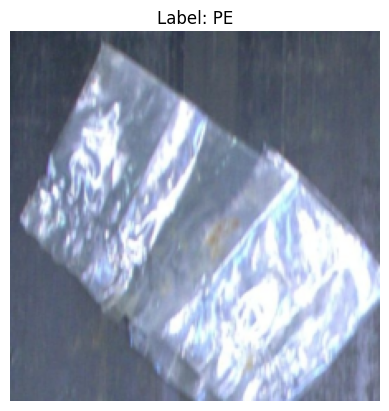

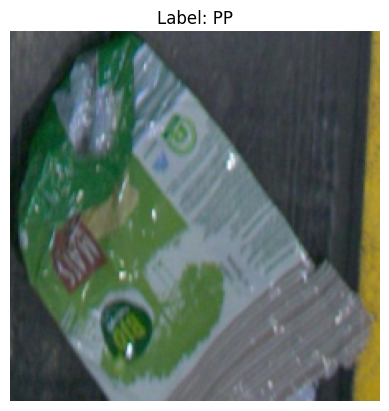

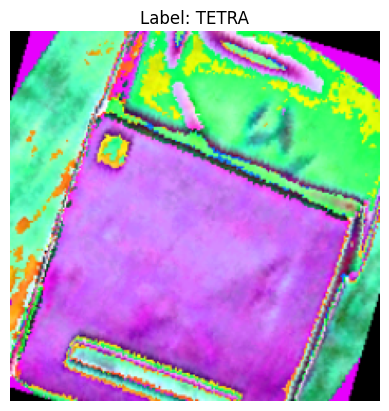

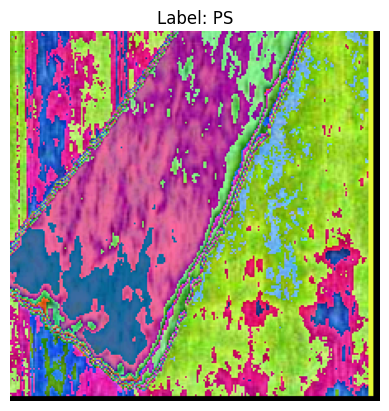

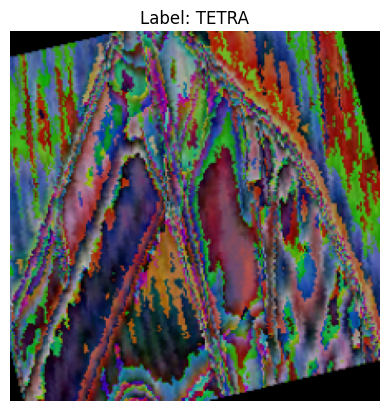

Displaying training images...
Training Images Shape: torch.Size([32, 3, 224, 224]), Training Labels Shape: torch.Size([32])


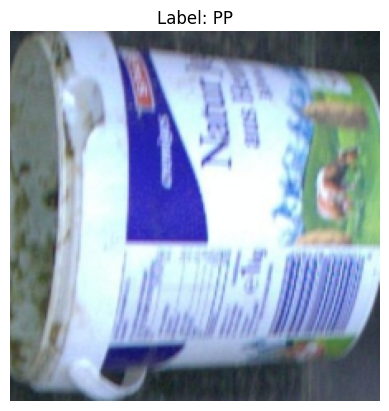

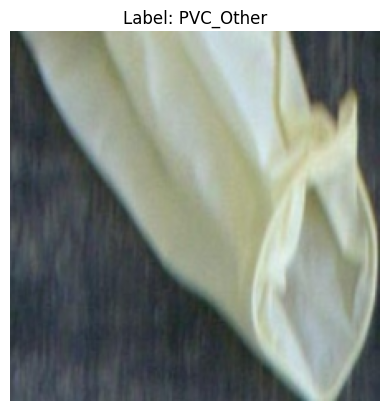

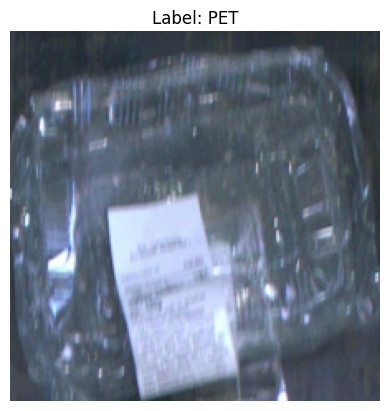

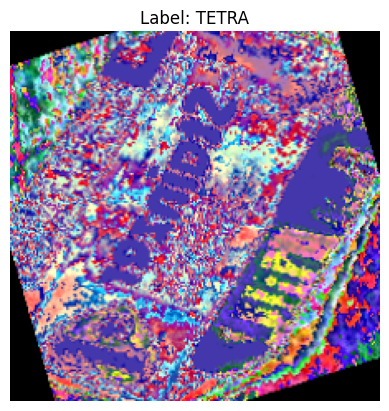

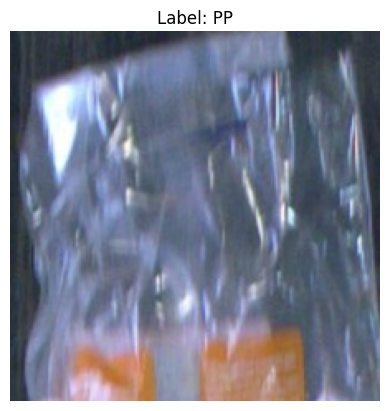

Displaying validation images...
Validation Images Shape: torch.Size([32, 3, 224, 224]), Validation Labels Shape: torch.Size([32])


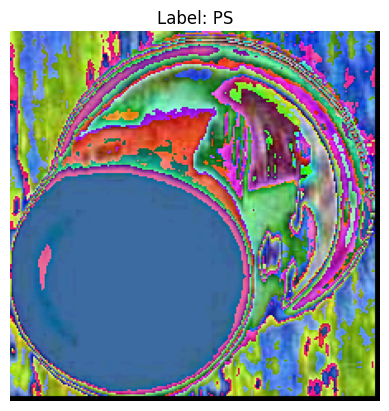

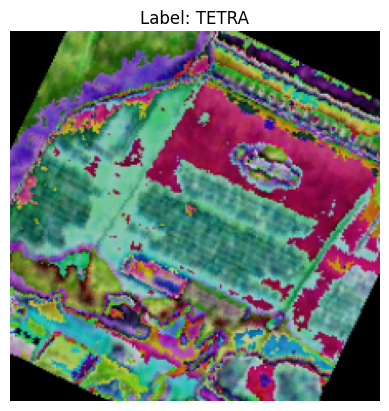

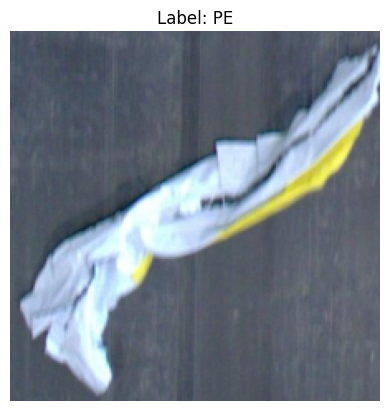

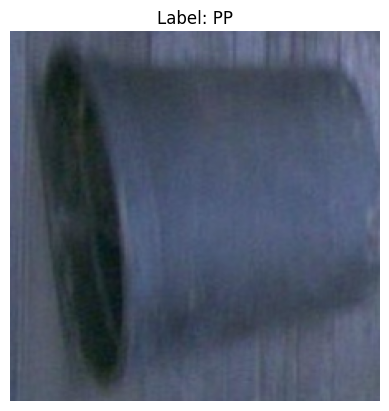

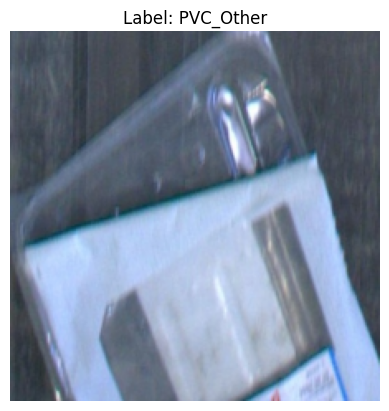

Training Labels: tensor([1, 5, 0, 3, 1, 1, 0, 1, 0, 3, 3, 2, 0, 2, 0, 4, 0, 3, 2, 3, 5, 2, 5, 4,
        5, 0, 4, 2, 4, 2, 4, 5])
Validation Labels: tensor([4, 3, 2, 1, 5, 0, 1, 1, 4, 4, 3, 1, 1, 1, 5, 5, 4, 2, 0, 0, 1, 5, 5, 5,
        4, 4, 4, 4, 5, 1, 1, 0])


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Define how many images to show
num_images_to_show = 5  # Adjust this as needed

# Function to show individual images with their labels
def show_image(image, label, class_names):
    image = image.cpu().numpy()  # Move tensor to CPU and convert to numpy
    image = np.transpose(image, (1, 2, 0))  # Transpose to (H, W, C)
    
    # Unnormalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean  # Revert normalization
    image = np.clip(image, 0, 1)  # Clip values to [0, 1]

    plt.imshow(image)
    plt.title(f"Label: {class_names[label]}")
    plt.axis("off")
    plt.show()

# Updated class names for visualization (consistent with class mapping)
class_names = [
    'PET',      # Combined from BigBag2 and BigBag4
    'PP',       # Combined from BigBag2 and BigBag4
    'PE',       # Combined from BigBag2 and BigBag4
    'TETRA',    # Combined from BigBag2 and BigBag4
    'PS',        # Combined from BigBag2 and BigBag4
    'PVC_Other' # Add combined class name
]

# Directory where all class folders are stored
data_dir = '/raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/data'

# Create dataset instance
plastic_dataset = CustomPlasticDataset(
    root_dir=data_dir, 
    class_mapping=class_mapping, 
    transform=regular_transform,
    tetra_transform=tetra_transform,
    ps_transform=ps_transform
)

# Show a few random images with their labels
for _ in range(num_images_to_show):
    idx = random.randint(0, len(plastic_dataset) - 1)  # Get a random index
    image, label = plastic_dataset[idx]  # Get the image and label
    show_image(image, label, class_names)  # Display the image
    
    
    # Function to fetch and display images from a DataLoader
def fetch_and_display_images(data_loader, num_images_to_show, class_names, dataset_type='Training'):
    images, labels = None, None  # Initialize variables
    
    try:
        data_iter = iter(data_loader)
        images, labels = next(data_iter)
        print(f"Displaying {dataset_type.lower()} images...")
        print(f"{dataset_type} Images Shape: {images.shape}, {dataset_type} Labels Shape: {labels.shape}")
    except IndexError as e:
        print(f"Error while fetching {dataset_type.lower()} data: {e}")
        return None, None  # Return None for both if there's an error
    
    # Show images only if they were successfully fetched
    if images is not None and labels is not None:
        for i in range(min(num_images_to_show, len(images))):
            show_image(images[i], labels[i].item(), class_names)

    return labels  # Return the fetched labels

# Display training images and store labels
train_labels = fetch_and_display_images(train_loader, num_images_to_show, class_names, dataset_type='Training')

# Display validation images and store labels
val_labels = fetch_and_display_images(val_loader, num_images_to_show, class_names, dataset_type='Validation')

# Print the labels
print("Training Labels:", train_labels)
print("Validation Labels:", val_labels)

In [20]:
import numpy as np
from torch.utils.data import random_split, ConcatDataset

# Split each client's images into 1 initial batch and 6 incremental batches
initial_split_size = 1059  # First client's batch size
num_incremental_batches = 6  # Number of incremental batches
new_data_per_batch = 300  # New images per incremental batch
replay_size = 300  # Replay size (previously seen data to include)

# Adjust initial sizes for other clients
initial_sizes = [initial_split_size] + [1058] * 3  # First client gets 1059, others get 1058
client_splits_cl = []

# Iterate over all clients to create incremental splits
for client_idx, client_dataset in enumerate(client_splits):
    # Ensure the first split size is appropriate
    if client_idx == 0:
        first_split, remaining_dataset = random_split(client_dataset, [initial_split_size, len(client_dataset) - initial_split_size])
    else:
        first_split, remaining_dataset = random_split(client_dataset, [initial_sizes[client_idx], len(client_dataset) - initial_sizes[client_idx]])
    
    # Check if we have enough images to split into incremental batches
    total_new_images_needed = new_data_per_batch * num_incremental_batches
    if len(remaining_dataset) < total_new_images_needed:
        print(f"Not enough remaining images for Client {client_idx + 1} to create incremental batches.")
        continue  # Skip this client if not enough images

    # Split the remaining dataset into 6 incremental batches of 300 new images each
    incremental_splits = random_split(remaining_dataset, [new_data_per_batch] * num_incremental_batches)

    # Store the initial split as the first batch
    client_splits_for_cl = [first_split]
    
    # Create incremental batches with replay technique
    for i in range(num_incremental_batches):
        # Get the previous seen data from all earlier batches
        previous_data = ConcatDataset(client_splits_for_cl)
        
        # Select 300 random previously seen images (for replay)
        replay_data, _ = random_split(previous_data, [replay_size, len(previous_data) - replay_size])
        
        # Create the new batch with 300 new images and 300 replay images
        new_batch = ConcatDataset([incremental_splits[i], replay_data])
        
        # Add this new batch to the client's splits
        client_splits_for_cl.append(new_batch)
    
    client_splits_cl.append(client_splits_for_cl)

# Verify the incremental splits for each client
for client_idx, splits in enumerate(client_splits_cl):
    for i, split in enumerate(splits):
        print(f"Client {client_idx + 1} - Batch {i + 1}: {len(split)} images")

Client 1 - Batch 1: 1059 images
Client 1 - Batch 2: 600 images
Client 1 - Batch 3: 600 images
Client 1 - Batch 4: 600 images
Client 1 - Batch 5: 600 images
Client 1 - Batch 6: 600 images
Client 1 - Batch 7: 600 images
Client 2 - Batch 1: 1058 images
Client 2 - Batch 2: 600 images
Client 2 - Batch 3: 600 images
Client 2 - Batch 4: 600 images
Client 2 - Batch 5: 600 images
Client 2 - Batch 6: 600 images
Client 2 - Batch 7: 600 images
Client 3 - Batch 1: 1058 images
Client 3 - Batch 2: 600 images
Client 3 - Batch 3: 600 images
Client 3 - Batch 4: 600 images
Client 3 - Batch 5: 600 images
Client 3 - Batch 6: 600 images
Client 3 - Batch 7: 600 images
Client 4 - Batch 1: 1058 images
Client 4 - Batch 2: 600 images
Client 4 - Batch 3: 600 images
Client 4 - Batch 4: 600 images
Client 4 - Batch 5: 600 images
Client 4 - Batch 6: 600 images
Client 4 - Batch 7: 600 images


In [21]:
import os
import torch
from torchvision import models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

# Model Preparation Function (ResNet18 for DWRL)
def prepare_model(num_classes=6, use_dropout=False, dropout_prob=0.2):
    """Load a pre-trained ResNet18 model and modify it for DWRL with optional dropout."""
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    if use_dropout:
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(num_ftrs, num_classes)
        )
    else:
        model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training function for Continual Learning
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, patience=5, min_delta=0):
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    return model

# Testing function to evaluate the model on the test set
def test_model(model, test_loader):
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * test_correct / test_total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

# Save function
def save_model(model, client_idx, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, f'client_{client_idx}_model.pth')
    torch.save(model.state_dict(), model_path)
    print(f'Model for Client {client_idx} saved at {model_path}')

# Prepare the training and validation loaders for each client
batch_size = 32
num_workers = 4
num_epochs = 5  # Set the number of epochs for each CL round

# Define the directory to save the models
save_dir = '/raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/models/'

# Iterate over all clients and perform incremental training (CL)
for client_idx, client_batches in enumerate(client_splits_cl):
    print(f"\nStarting Continual Learning for Client {client_idx + 1}...")

    # Initialize the model once for each client, and then update it for each batch
    model = prepare_model(num_classes=6).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Train on each batch incrementally, continuing from the last updated model
    for batch_idx, batch in enumerate(client_batches):
        print(f"Training on Batch {batch_idx + 1}/{len(client_batches)}")

        # Create DataLoader for the current batch
        train_loader = DataLoader(batch, batch_size=batch_size, shuffle=True, num_workers=num_workers)

        # Use the same validation set for all batches
        model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

    # After training on all batches, test the model on the test set
    print(f"Testing model for Client {client_idx + 1} after Continual Learning...")
    test_model(model, test_loader)

    # Save the model for each client
    save_model(model, client_idx + 1, save_dir)

print("Continual Learning, testing, and saving models for all clients completed.")


Starting Continual Learning for Client 1...


/raid/home/somayeh.shami/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/raid/home/somayeh.shami/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training on Batch 1/7
Epoch 1/5, Train Loss: 1.0447, Train Accuracy: 57.32%, Val Loss: 0.7196, Val Accuracy: 71.17%
Epoch 2/5, Train Loss: 0.3665, Train Accuracy: 90.46%, Val Loss: 0.6498, Val Accuracy: 74.32%
Epoch 3/5, Train Loss: 0.1649, Train Accuracy: 97.73%, Val Loss: 0.6499, Val Accuracy: 75.65%
Epoch 4/5, Train Loss: 0.0861, Train Accuracy: 98.87%, Val Loss: 0.6503, Val Accuracy: 76.42%
Epoch 5/5, Train Loss: 0.0589, Train Accuracy: 99.34%, Val Loss: 0.7196, Val Accuracy: 74.32%
Training on Batch 2/7
Epoch 1/5, Train Loss: 0.3916, Train Accuracy: 87.83%, Val Loss: 0.7499, Val Accuracy: 72.78%
Epoch 2/5, Train Loss: 0.1083, Train Accuracy: 97.00%, Val Loss: 0.7010, Val Accuracy: 76.63%
Epoch 3/5, Train Loss: 0.0497, Train Accuracy: 99.33%, Val Loss: 0.7256, Val Accuracy: 75.86%
Epoch 4/5, Train Loss: 0.0503, Train Accuracy: 99.33%, Val Loss: 0.7352, Val Accuracy: 76.63%
Epoch 5/5, Train Loss: 0.0227, Train Accuracy: 99.50%, Val Loss: 0.7166, Val Accuracy: 77.12%
Training on Batc

In [23]:
from torch.utils.data import DataLoader, random_split

# Function to create DataLoaders for each client
def create_client_loaders(dataset, num_clients=4, batch_size=32, val_split=0.1, num_workers=4):
    """Split dataset into `num_clients` parts and create train/validation loaders."""
    client_loaders = []
    val_loaders = []
    
    # Calculate sizes for each client
    client_sizes = [len(dataset) // num_clients] * num_clients
    for i in range(len(dataset) % num_clients):
        client_sizes[i] += 1  # Distribute the remainder

    # Split the dataset randomly into `num_clients` parts
    client_datasets = random_split(dataset, client_sizes)
    
    for client_dataset in client_datasets:
        # Further split each client's dataset into train and validation sets
        train_size = int((1 - val_split) * len(client_dataset))
        val_size = len(client_dataset) - train_size
        train_dataset, val_dataset = random_split(client_dataset, [train_size, val_size])
        
        # Create DataLoaders for the client with pin_memory and optimizations
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                  num_workers=num_workers, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                                num_workers=num_workers, pin_memory=True)
        
        client_loaders.append(train_loader)
        val_loaders.append(val_loader)
    
    return client_loaders, val_loaders

# Assuming `train_dataset` is your training dataset from DWRL
client_train_loaders, client_val_loaders = create_client_loaders(train_dataset, num_clients=4, batch_size=32, num_workers=4)

# Verify the sizes of the loaders for each client
for i, (train_loader, val_loader) in enumerate(zip(client_train_loaders, client_val_loaders)):
    print(f"Client {i+1} - Training set size: {len(train_loader.dataset)}")
    print(f"Client {i+1} - Validation set size: {len(val_loader.dataset)}")

Client 1 - Training set size: 2573
Client 1 - Validation set size: 286
Client 2 - Training set size: 2572
Client 2 - Validation set size: 286
Client 3 - Training set size: 2572
Client 3 - Validation set size: 286
Client 4 - Training set size: 2572
Client 4 - Validation set size: 286


### Step 6a: BASELINE(FL After Full Continual Learning" (FL-FCL))- Apply Federated Learning (FL) After Continual Learning (CL)
#### Federated Averaging: We collect the models from each client after CL, average their weights, and load the averaged weights into the global model.
#### Test the Global Model: After aggregation, the global model is tested on the test set, and the test accuracy is reported.

In [27]:
import os
import torch.optim as optim
import torch.nn as nn
from torchvision import models
from torch.cuda.amp import autocast, GradScaler  # For mixed-precision training

# Path where client models are saved
#saved_models_dir = '/raid/home/somayeh.shami/project/somayeh_workspace/federated_learning/cl_models/'
save_dir = '/raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/models/'

# Model Preparation (ResNet18 for DWRL)
def prepare_model(num_classes=6, use_dropout=False, dropout_prob=0.2):
    """Load a pre-trained Resnet18 model and modify it for DWRL with optional dropout."""
    model = models.resnet18(weights='DEFAULT')  # Adjusted to use the new weights parameter
    num_ftrs = model.fc.in_features
    if use_dropout:
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(num_ftrs, num_classes)
        )
    else:
        model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# Function to load a model from a file
def load_client_model(client_idx, save_dir, num_classes=6):
    model = prepare_model(num_classes=num_classes).to(device)  # Specify the correct num_classes
    model_path = os.path.join(save_dir, f'client_{client_idx}_model.pth')
    
    # Load the state dict with strict=False to ignore mismatched keys
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict, strict=False)
    
    print(f'Loaded model for Client {client_idx} from {model_path}')
    return model

# Function to average client models (FL aggregation)
def federated_averaging(state_dicts):
    avg_state_dict = {}
    for key in state_dicts[0].keys():
        avg_state_dict[key] = sum(state_dict[key] for state_dict in state_dicts) / len(state_dicts)
    return avg_state_dict

# Training function for each client after receiving the global model
def fine_tune_client(global_model, train_loader, val_loader, num_epochs=3, use_mixed_precision=True):
    model = global_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # Optional: Mixed precision training
    scaler = GradScaler() if use_mixed_precision else None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            if use_mixed_precision:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.2f}%')

    return model.state_dict()

# Step 6: Federated Learning (FL) after Continual Learning (CL)
def apply_federated_learning(cl_models, train_loaders, val_loaders, test_loader, num_clients=4, num_epochs=3):
    global_model = prepare_model().to(device)

    # Collect state dicts from all clients after CL
    state_dicts = [model.state_dict() for model in cl_models]

    # Perform federated averaging
    avg_state_dict = federated_averaging(state_dicts)
    global_model.load_state_dict(avg_state_dict)

    for round in range(num_epochs):
        print(f'\n--- Federated Learning Round {round + 1} ---')
        client_state_dicts = []

        for client_idx in range(num_clients):
            print(f'\nTraining client {client_idx + 1} with the global model')
            client_state_dict = fine_tune_client(global_model, train_loaders[client_idx], val_loaders[client_idx], num_epochs=3)
            client_state_dicts.append(client_state_dict)

        # Federated averaging after each round
        avg_state_dict = federated_averaging(client_state_dicts)
        global_model.load_state_dict(avg_state_dict)

        test_accuracy = test_global_model(global_model, test_loader)
        print(f'Test Accuracy after Round {round + 1}: {test_accuracy:.2f}%')

    return global_model

# Function to test the global model
def test_global_model(model, test_loader):
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    return test_accuracy

# Load models saved after CL
cl_models = [load_client_model(client_idx, save_dir, num_classes=6) for client_idx in range(1, 5)]

# Prepare DataLoader splits for each client with pin_memory=True and fewer workers
train_loaders, val_loaders = create_client_loaders(train_dataset, num_clients=4, batch_size=32)

# Apply FL and test the global model
global_model = apply_federated_learning(cl_models, train_loaders, val_loaders, test_loader)

Loaded model for Client 1 from /raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/models/client_1_model.pth
Loaded model for Client 2 from /raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/models/client_2_model.pth
Loaded model for Client 3 from /raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/models/client_3_model.pth
Loaded model for Client 4 from /raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/models/client_4_model.pth

--- Federated Learning Round 1 ---

Training client 1 with the global model
Epoch 1/3, Train Accuracy: 82.12%
Epoch 2/3, Train Accuracy: 95.69%
Epoch 3/3, Train Accuracy: 98.41%

Training client 2 with the global model
Epoch 1/3, Train Accuracy: 83.05%
Epoch 2/3, Train Accuracy: 96.89%
Epoch 3/3, Train Accuracy: 99.30%

Training client 3 with the global model
Epoch 1/3, Train Accuracy: 83.44%
Epoch 2/3, Train Accuracy: 96.77%
Epoch 3/3, Train Accuracy: 99.14%

Training client 4 with the global model
Epoch 1/3, Train Accuracy: 83.63%
Epoc

## Step 6b: (FL After Each Continual Learning Round (FL-CL)) - Apply Federated Learning (FL) After Each CL Round
- **Federated Averaging**: After each client completes a round of CL (training on a batch), we perform FL by averaging the client models.
- **Global Model Updates**: The aggregated global model is redistributed to all clients before continuing with the next batch.
- **Testing**: The global model is tested after each FL round to evaluate its performance.

In [29]:
import os
import torch.optim as optim
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader

# Path where client models are saved
saved_models_dir = '/raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/models/'

# Model Preparation (ResNet18 for DWRL)
def prepare_model(num_classes=6, use_dropout=False, dropout_prob=0.2):
    """Load a pre-trained ResNet18 model and modify it for DWRL with optional dropout."""
    model = models.resnet18(weights='DEFAULT')  # Update to use weights argument
    num_ftrs = model.fc.in_features
    if use_dropout:
        model.fc = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(num_ftrs, num_classes)
        )
    else:
        model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# Function to load a model from a file
def load_client_model(client_idx, save_dir):
    model = prepare_model(num_classes=6).to(device)
    model_path = os.path.join(save_dir, f'client_{client_idx}_model.pth')
    model.load_state_dict(torch.load(model_path))
    print(f'Loaded model for Client {client_idx} from {model_path}')
    return model

# Function to average client models (FL aggregation)
def federated_averaging(state_dicts):
    avg_state_dict = {}
    for key in state_dicts[0].keys():
        avg_state_dict[key] = sum(state_dict[key] for state_dict in state_dicts) / len(state_dicts)
    return avg_state_dict

# Training function for each client after receiving the global model
def fine_tune_client(global_model, train_loader, val_loader, num_epochs=3):  # Adjusted to 3 epochs
    model = global_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_accuracy:.2f}%')

    return model.state_dict()  # Return the fine-tuned state_dict


# Step 6: Federated Learning (FL) after each batch of Continual Learning (CL)
# Assume client_splits_cl is correctly initialized with batch splits for each client.
# Check if client_splits_cl is correctly defined with the expected shape.

def apply_federated_learning_after_each_batch(client_splits_cl, val_loaders, test_loader, num_clients=4, num_epochs=3):
    # Initialize a global model
    global_model = prepare_model(num_classes=6).to(device)

    # Iterate over each batch of CL for all clients
    for batch_idx in range(len(client_splits_cl[0])):  
        print(f'\n--- Training and Federated Learning after Batch {batch_idx + 1} ---')

        client_state_dicts = []

        for client_idx in range(num_clients):
            print(f'\nTraining client {client_idx + 1} on Batch {batch_idx + 1}')

            # Create DataLoader for the current batch
            train_loader = DataLoader(client_splits_cl[client_idx][batch_idx], batch_size=32, shuffle=True)

            # Fine-tune client model with the current global model
            client_state_dict = fine_tune_client(global_model, train_loader, val_loaders[client_idx], num_epochs=num_epochs)
            client_state_dicts.append(client_state_dict)

        # Perform federated averaging after this batch for all clients
        avg_state_dict = federated_averaging(client_state_dicts)
        global_model.load_state_dict(avg_state_dict)

        # Optionally test the global model after each batch
        test_accuracy = test_global_model(global_model, test_loader)
        print(f'Test Accuracy after Batch {batch_idx + 1}: {test_accuracy:.2f}%')

    return global_model

# Make sure to load models saved after Continual Learning (CL) as before
cl_models = [load_client_model(client_idx, saved_models_dir) for client_idx in range(1, 5)]

# Ensure that client_splits_cl is defined properly with the batches
global_model = apply_federated_learning_after_each_batch(client_splits_cl, val_loaders, test_loader, num_clients=4, num_epochs=3)

Loaded model for Client 1 from /raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/models/client_1_model.pth
Loaded model for Client 2 from /raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/models/client_2_model.pth
Loaded model for Client 3 from /raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/models/client_3_model.pth
Loaded model for Client 4 from /raid/home/somayeh.shami/project/somayeh_workspace/DWRL7/models/client_4_model.pth

--- Training and Federated Learning after Batch 1 ---

Training client 1 on Batch 1
Epoch 1/3, Train Accuracy: 55.90%
Epoch 2/3, Train Accuracy: 88.86%
Epoch 3/3, Train Accuracy: 97.36%

Training client 2 on Batch 1
Epoch 1/3, Train Accuracy: 74.20%
Epoch 2/3, Train Accuracy: 92.63%
Epoch 3/3, Train Accuracy: 98.58%

Training client 3 on Batch 1
Epoch 1/3, Train Accuracy: 72.40%
Epoch 2/3, Train Accuracy: 94.61%
Epoch 3/3, Train Accuracy: 98.68%

Training client 4 on Batch 1
Epoch 1/3, Train Accuracy: 77.79%
Epoch 2/3, Train Accuracy: 96